In [ ]:
! pip install langchain_core langchain-openai langgraph python-dotenv

In [ ]:
from dotenv import load_dotenv
load_dotenv

In [14]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [15]:
from pydantic import BaseModel, Field
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web Search")
    justification: str = Field(None, description="Why this query is relevent to the user's request")

#Augment the llm with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

#Invoke the augmented llm
output = structured_llm.invoke("How does calcia, CT score related to high chelosterol?")
print(output.search_query)
print(output.justification) 

Calcium CT Score and High Cholesterol Relationship
To explore the link between calcium CT scores, also known as coronary artery calcium (CAC) scores, and high cholesterol levels, consider how cholesterol contributes to the buildup of plaque in arteries, which can lead to calcification detectable by CT scans.


In [16]:
#Define a tool 
def multiply(a:int, b:int)->int:
    return a*b

#augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("What is 2 times 3?")

#Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_Ol9mWXFiZjGUx2ofOfaELskR',
  'type': 'tool_call'}]

### Workflow: Prompt chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

### When to use this workflow: 
This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

#### Examples where prompt chaining is useful:

* Generating Marketing copy, then translating it into a different language.
* Writing an outline of a document, checking that the outline meets certain criteria, then writing the document based on the outline.

* Example: Take a topic, LLM makes a joke, check the joke, improve it twicem

In [19]:
from typing_extensions import TypedDict

#Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [21]:
def generate_joke(state: State):
    """First LLm call to generate a joke"""
    msg = llm.invoke(f"Write a joke about {state["topic"]}")
    return {'joke':msg.content}

def improve_joke(state: State):
    """second LLM call to immprove joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state["joke"]}")
    return {'improved_joke': msg.content}

def polish_joke(state: State):
    """third LLM call for final poslish """
    msg = llm.invoke(f"Add surprising twist to this joke: {state['improved_joke']} ")
    return {'final_joke': msg.content}

#conditional edge function to check if the joke has a punchline
def check_punchline(state:State):
    """Gate function to check if the joke has a punchline"""
    #Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

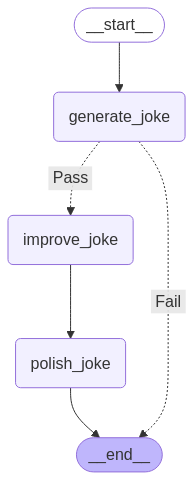

In [25]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

#Build the workflow
workflow = StateGraph(State)

#add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

#Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Pass":"improve_joke", "Fail":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

#Compile the chain
chain = workflow.compile()

#Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [26]:
# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Why was the cat sitting on the computer?  

Because it heard the Wi-Fi was purr-fect and wanted to keep an eye on the mouse before it logged out!

--- --- ---

Final joke:
Why was the cat sitting on the computer?

Because it heard the Wi-Fi was purr-fect and wanted to keep an eye on the mouse before it logged out—little did it know, the "mouse" had just ordered a giant bag of dog treats online!


### Workflow: Parallelization
#### LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations:

* Sectioning: Breaking a task into independent subtasks run in parallel.
* Voting: Running the same task multiple times to get diverse outputs.

#### When to use this workflow:
Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

Examples where parallelization is useful:

* Sectioning:
Implementing guardrails where one model instance processes user queries while another screens them for inappropriate content or requests. This tends to perform better than having the same LLM call handle both guardrails and the core response.
Automating evals for evaluating LLM performance, where each LLM call evaluates a different aspect of the model’s performance on a given prompt.
* Voting:
Reviewing a piece of code for vulnerabilities, where several different prompts review and flag the code if they find a problem.
Evaluating whether a given piece of content is inappropriate, with multiple prompts evaluating different aspects or requiring different vote thresholds to balance false positives and negatives.

### Example: Take a topic , create a joke, story and poemm

In [35]:
from typing_extensions import TypedDict


class State(TypedDict):
    topic : str
    joke  : str
    story : str
    poem  : str
    combined_output: str

In [36]:
#Node
def call_llm_1(state:State):
    """First LLm call to generate the Joke"""
    msg = llm.invoke(f"Write a funny joke about the topic {state['topic']}")
    return {"joke":msg.content}


def call_llm_2(state:State):
    """Second LLM call to generate a story"""
    msg = llm.invoke(f"Write a Story about the topic: {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state:State):
    """Third LLM call to generate a poem """
    msg = llm.invoke(f"write a poem about the topic: {state['topic']}")
    return {"poem":msg.content}


def aggregator(state:State):
    """combined the joke,story and poem into single output"""
    combined = f"Here's a story, joke and poem about {state['topic']}!\n\n"
    combined +=f"STORY:\n{state['story']}\n\n"
    combined +=f"JOKE\n{state['joke']}\n\n"
    combined +=f"POEM\n{state['poem']}\n\n"
    return {'combined_output': combined}

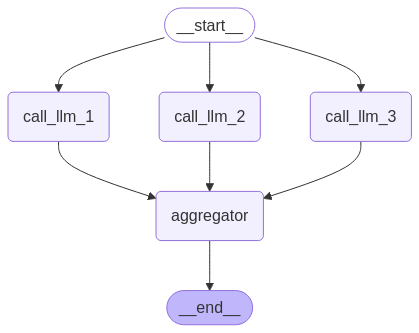

In [37]:
from langgraph.graph import StateGraph, START, END
parallel_builder = StateGraph(State)

parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)


parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")


parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")

parallel_builder.add_edge("aggregator", END)


paraller_workflow = parallel_builder.compile()


display(Image(paraller_workflow.get_graph().draw_mermaid_png()))



In [38]:
state = paraller_workflow.invoke({'topic':'cats'})
print(state["combined_output"])

Here's a story, joke and poem about cats!

STORY:
Once upon a time, in a quaint village named Whiskerville, nestled at the edge of a sprawling forest, the villagers shared their lives with countless cats. These weren't ordinary cats; they had stories that made them the stuff of local legends. 

In the heart of Whiskerville lived an elder cat, Bartholomew, who was as wise as the village was old. His fur was a mix of stormy gray and silver, giving him an air of dignity and mystery. Bartholomew was revered among both felines and humans for his unparalleled wisdom and guidance. It was said he had walked the cobblestone streets since the village was just a budding settlement.

The village folklore was filled with tales of how the cats of Whiskerville were not mere animals but possessed magical abilities. Most noteworthy was their talent for communication. The villagers believed that when the moon was full and the stars aligned just right, these cats could truly speak the language of humans.

### Workflow: Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.


#### The routing workflow
When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

#### Examples where routing is useful:

Directing different types of customer service queries (general questions, refund requests, technical support) into different downstream processes, prompts, and tools.
Routing easy/common questions to smaller models like Claude 3.5 Haiku and hard/unusual questions to more capable models like Claude 3.5 Sonnet to optimize cost and speed.

### Example: Route an input between joke, story and poem

In [39]:
from typing_extensions import Literal
#Schema for structured output to use a s routing logic 
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next in routing process"
    )


#Augmented the llm with schema for structured output
router = llm.with_structured_output(Route)

In [40]:
class State(TypedDict):
    input: str
    decision: str
    output: str

In [41]:
# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

In [44]:
def llm_call_router(state:State):
    """Route the input to the appropriate node"""
    #Run the augmented LLM with structured output to serve s routing logic
    decision = router.invoke( f"Route the input to story, joke or poem based on the user's request, Human Query: {state['input']} "
    )
    return {'decision':decision.step}


def route_decision(state:State):
    if state["decision"]=="story":
        return "llm_call_1"
    elif state["decision"]=="joke":
        return "llm_call_2"
    elif state["decision"]=="poem":
        return "llm_call_3"



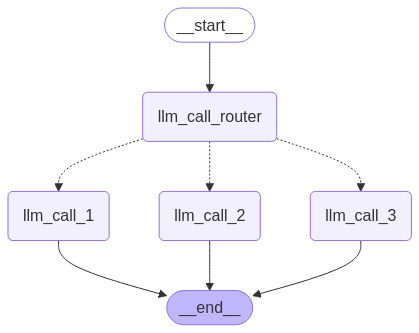

Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse!


In [48]:

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

### Workflow: Orchestrator-workers
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.


#### The orchestrator-workers workflow
When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

#### Example where orchestrator-workers is useful:
* Coding products that make complex changes to multiple files each time.
* Search tasks that involve gathering and analyzing information from multiple sources for possible relevant information.

#### Example: Take a topic, plan a report of section, have each worker write a section

In [56]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

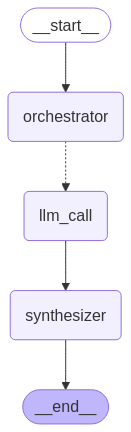

In [67]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
            "SystemMessage:'Generate a plan for the report."
            f"HumanMessage: 'Here is the report topic: {state['topic']}'")
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        "SystemMessage:'Write a report section following the provided name and description. "
        "Include no preamble for each section. Use markdown formatting.', "
        f"HumanMessage:'Here is the section name: {state['section'].name} "
        f"and description: {state['section'].description}'"
    )
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))



In [68]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction

In recent years, the field of machine learning and artificial intelligence has witnessed significant advancements, with large language models (LLMs) standing out as some of the most transformative developments. These models have demonstrated remarkable capabilities in understanding and generating human language, powering applications ranging from chatbots and virtual assistants to complex content creation and automated translation services. Central to the development and refinement of these models are LLM scaling laws, which provide critical insights into how the performance of these models scales with increased resources, such as data, compute power, and model parameters.

The significance of LLM scaling laws lies in their utility for both researchers and practitioners seeking to optimize AI systems. They offer a foundational understanding of how changes in model size, training data volume, and computational resources influence model capabilities and efficiencies. By systematically evaluating these relationships, scaling laws inform decisions around resource allocation and model deployment, ensuring that organizations can achieve optimal performance outcomes with minimal costs.

Moreover, scaling laws serve as guiding principles for pushing the boundaries of what LLMs can achieve, revealing potential trade-offs and diminishing returns associated with scaling up these models. This understanding is pivotal as the industry continues to grapple with challenges related to model interpretability, fairness, and sustainability. As the demand for more powerful and sophisticated AI systems grows, the implications of LLM scaling laws become increasingly crucial for shaping the future trajectories of AI research and application. This report aims to delve into the intricacies of these scaling laws, exploring their practical applications and the broader impacts they hold for the domain of machine learning and AI.

---

## Background and Context

The development of language learning models (LLMs) has rapidly evolved, especially over the past few decades, due to advances in computational power, algorithmic innovation, and the increasing availability of large datasets. The journey from early natural language processing efforts to sophisticated LLMs like OpenAI's GPT-3 and Google's BERT marks a significant transformation in how machines understand and generate human language.

### Early Developments in Language Models

Language models started as simple statistical representations that could predict the next word in a sentence based on previous ones. Early models, like n-gram models, relied heavily on probability and frequency analysis extracted from textual corpuses. These models, however, had limitations in capturing the complexities of human language due to the sparsity of data and the exponential growth in possible word sequences as the context length increased.

### The Emergence of Neural Language Models

The introduction of neural networks revolutionized the field. Recurrent Neural Networks (RNNs) and later Long Short-Term Memory networks (LSTMs) offered mechanisms to better capture dependencies in text data. These models improved context handling by maintaining information through cycles, allowing for sequential data processing, albeit still constrained by issues like vanishing gradients.

The introduction of the Attention mechanism and Transformer architecture, as presented by Vaswani et al. in 2017, addressed many earlier limitations. The Transformer model's self-attention mechanism enhanced the ability of language models to process sequences by considering the importance of different words irrespective of their position in the sequence. This innovation set the stage for subsequent developments in LLMs and played a critical role in the evolution of scaling laws.

### Scaling Laws and their Evolution

Scaling laws refer to the principles that describe how certain properties of a system, such as performance or efficiency, change with size or scale. In the context of machine learning and LLMs, scaling laws describe how metrics like model accuracy or complexity evolve with factors such as dataset size, model parameters, and computational resources.

In research by Kaplan et al. (2020), it was shown that LLMs like GPT-3 benefit significantly from increases in model size, data, and compute power, illustrating that model performance improves predictably as these inputs scale. They quantified these improvements as power-law relationships, providing a framework for anticipating enhancements with increased resource investments.

### The Impact of Scaling on LLMs

Understanding and leveraging scaling laws have become pivotal in advancing LLMs. With the formulation of scaling laws, researchers and practitioners can make informed decisions about resource allocation, guiding efficient transformations of computational and data resources into tangible performance improvements. As models scale, they capture increasingly nuanced linguistic features, leading to more robust, versatile, and generalized language models.

### Conclusion

The history of language learning models is marked by waves of innovation that have incrementally improved the capacity for machines to understand and generate natural language. With scaling laws providing a roadmap for the future, the field continues to evolve, offering promising potential for even greater capabilities in language processing and understanding. As computational resources and data availability expand, the trajectory set by these scaling laws will likely steer the ongoing advancements in LLMs.

---

## Fundamentals of LLM Scaling Laws

LLM scaling laws refer to the observed relationships between the size of large language models (LLMs) and various performance metrics. These laws illuminate how increasing a model's parameters, training data, or computational resources can potentially enhance its capabilities and efficiency. As a result, they provide crucial insights into optimizing model design for better performance.

### Mathematical Definition and Theory

Scaling laws are often expressed in mathematical forms that relate model size (number of parameters), dataset size, and computational power to performance metrics such as accuracy, loss reduction, or error rates. A typical mathematical representation of a scaling law might be:

\[ \text{Performance} = a \cdot (\text{Model Size})^b + c \cdot (\text{Data Size})^d + e \]

where \(a\), \(b\), \(c\), \(d\), and \(e\) are constants determined empirically. The model size refers to the total number of trainable parameters, data size denotes the volume of training data, and computational power is often measured in terms of floating-point operations per second (FLOPS).

A core theoretical underpinning is that, beyond a certain threshold, improvements in model performance exhibit diminishing returns. That is, doubling the number of parameters or training data does not necessarily double the performance, highlighting the non-linear nature of these relationships. This theory implies that there exists an optimal point where the proportional investment in data or model size yields the maximal performance gain per resource unit.

### Importance in Understanding Model Performance and Efficiency

Understanding LLM scaling laws is crucial for several reasons:

1. **Resource Allocation**: Identifying efficient scaling strategies allows developers to optimize the allocation of computational resources, ensuring that investments in larger models translate effectively into performance gains.

2. **Model Design**: Insights from scaling laws inform choices about model architecture and training regimes, guiding decisions such as the trade-off between increasing parameter size versus data size.

3. **Performance Prediction**: Scaling laws provide predictive power, enabling researchers and engineers to estimate the performance possible from given resources or to forecast the resources required to meet specific performance goals.

4. **Benchmarking and Evaluation**: They create a framework for benchmarking models against established performance baselines, helping to evaluate whether a new model or approach offers genuinely improved efficiency.

5. **Scientific Understanding**: On a more theoretical note, they contribute to a deeper scientific understanding of neural networks, shedding light on why some models generalize better than others and the inherent limitations of scaling.

In summary, LLM scaling laws are foundational to the field of machine learning, especially in the era of increasingly large and complex models. They serve not only as a tool for practical optimization but also propel forward the theoretical understanding of artificial intelligence models.

---

## Applications of LLM Scaling Laws

The scaling laws associated with large language models (LLMs) have been pivotal in advancing the state-of-the-art in natural language processing (NLP) and related fields. These laws provide insights into how models can be efficiently scaled in terms of parameters, data, and computational resources to enhance performance.

Scaling laws have been particularly influential in the following real-world applications:

### Optimizing Large-Scale Models

One of the most significant applications of LLM scaling laws is in the optimization of large-scale models. By understanding the relationship between model size, data size, and performance, researchers and engineers can design models that achieve desired performance levels without the need for excessive computational resources. This optimization process involves:
- **Determining the Optimal Model Size**: Scaling laws help identify the size of a model that will provide the best performance for a given amount of training data and computational budget. This prevents over-parameterization and reduces unnecessary computational expenditure.
- **Balancing Training Data and Parameters**: By adjusting the amount of training data in conjunction with model parameters, scaling laws assist in maximizing the model’s capability to generalize from data. This is particularly beneficial in domains where data may be scarce.
- **Efficient Utilization of Hardware**: Understanding how model size affects performance allows for better planning of the hardware resources needed for training. This helps in reducing costs and energy consumption.

### Improving Computational Efficiencies

Computational efficiency is another area where scaling laws have had a profound impact. The guidelines provided by these laws help in improving the overall efficiency of training large language models through:
- **Resource Allocation**: Scaling laws inform decisions about how computational resources should be allocated during model training. This can lead to significant cost savings and faster training times.
- **Parallelism and Distribution**: By comprehending the scaling properties, researchers can optimize the distribution of workloads across multiple processing units. This ensures that models are trained in a time-efficient manner without compromising on performance.
- **Benchmarking and Evaluation**: LLM scaling laws provide a framework for setting benchmarks and evaluating model performance relative to its size and training data. This standardization aids in comparing different models and determining the most efficient path to achieving state-of-the-art results.

In summary, the scaling laws of LLMs are indispensable tools in the development of robust, efficient, and high-performing language models. Their application not only reduces the complexity involved in model design and training but also enhances the overall effectiveness and sustainability of deploying large-scale models in practical, real-world scenarios.

---

## Challenges and Limitations

The scaling of large language models (LLMs) presents several significant challenges and limitations. These arise from the complexity and demands of training and maintaining such models. Key issues include overfitting, computational costs, and architectural constraints, each posing distinct hurdles to effective scaling.

### Overfitting

Overfitting is a persistent concern in the development of LLMs as they scale. As models become larger, they may begin to memorize the training data rather than generalizing from it. This results in decreased performance on unseen data, undermining the utility of the model. Managing overfitting requires careful attention to data diversity and augmentation and may necessitate innovative regularization techniques. Additionally, as LLMs grow, they need ever-larger and more diverse datasets to maintain generalization capabilities, which can be challenging to curate and balance.

### Computational Costs

The computational costs associated with scaling LLMs are another substantial obstacle. Training these models often demands immense computational resources, including powerful GPUs or TPUs and extensive memory capacity. This requirement implies significant financial and environmental costs, thereby limiting accessibility to well-funded institutions or companies. Furthermore, the energy consumption involved raises sustainability concerns, as it contributes to the carbon footprint of developing artificial intelligence technologies.

### Architectural Constraints

Current architectures for LLMs, primarily based on transformer models, impose certain constraints that challenge scaling efforts. While transformers are highly effective for a variety of natural language processing tasks, they require quadratic memory and computation concerning the input sequence length, which can become untenable as models and data increase. Innovations in model architectures or efficiency, such as sparse transformers or modifications of attention mechanisms, are necessary to overcome these limitations and facilitate more scalable solutions.

### Summary

Addressing these challenges requires a balanced approach that considers technical, economic, and environmental factors. Continued innovation in model architecture, optimization algorithms, and dataset management will be critical in overcoming the scaling limitations of LLMs. Simultaneously, a dialogue on ethical and sustainable practices in AI research and development is vital to ensure that advancements in LLMs align with broader societal values and goals.

---

## Recent Developments and Future Prospects

### Latest Research Findings

In recent years, research into large language models (LLMs) has made significant strides in understanding and applying scaling laws. A key study by OpenAI suggested that model performance improves predictably with increases in model size, dataset size, and the amount of compute used. These scaling laws have elucidated the diminishing returns and point to the efficiency of optimizing resources around model scale. Recent publications have expanded on these findings, confirming that larger models generally continue to perform better on a wide range of natural language processing tasks, given sufficient training data.

Further investigations have introduced the concept of “scaling laws beyond the power law,” which accounts for other effects, such as architecture modifications and hyperparameter optimizations. These findings provide a more nuanced understanding of scaling, emphasizing that while raw size contributes to model efficacy, thoughtful refinements to training methodology and model architecture can yield significant performance boosts without linearly increasing size or computational demand.

### Technological Advancements

Technological advancements have paralleled these research findings, facilitating more efficient scaling of LLMs. Innovations in hardware, like the development of specialized AI accelerators and improvements in GPU technology, have driven down the time and cost required to train these massive models. Additionally, software optimizations, such as gradient checkpointing and mixed precision training, have been instrumental in reducing the memory and computational demands typically associated with LLM training.

The advent of distributed training techniques allows for the simultaneous utilization of multiple computing nodes, making it possible to train extraordinarily large models that were not feasible just a few years ago. Moreover, advancements in optimization algorithms, such as more adaptive learning rates and improved weight initialization strategies, have accelerated convergence rates, thereby enhancing the overall training efficiency.

### Potential Future Trends

Looking ahead, the trajectory of research and technological development in LLM scaling suggests several promising trends. One potential direction is the increased focus on model efficiency rather than mere size. With environmental and economic considerations playing a more prominent role, there is likely to be an emphasis on developing smaller, more efficient models that match or exceed the performance of their larger counterparts. Techniques like knowledge distillation and model pruning will likely feature heavily in this push towards leaner models.

Another anticipated trend is the refinement of multimodal LLMs, which integrate language processing with other data modalities, such as visual and auditory signals. These models could benefit from scaling laws, obtaining versatility and robustness across diverse applications, from real-time translation to advanced content generation.

Finally, as ethical considerations gain traction, future research might focus on developing guidelines and frameworks that govern the responsible scaling of LLMs. This would promote equitable access, minimize environmental impacts, and ensure that AI advances serve broad societal interests while mitigating biases inherent in large language models.

In summary, the field of LLM scaling laws is on the cusp of exciting developments that promise to redefine the capabilities and applications of AI in natural language processing and beyond. As research continues to unlock new insights and inform technological progress, the future of LLMs appears poised for remarkable evolution.

---

## Case Studies

### 1. OpenAI and GPT-3 Implementation

**Organization:** OpenAI  
**Strategy:** Leveraging Large Language Models (LLMs) and scaling laws to improve natural language processing capabilities.  
**Implementation:** OpenAI's development of GPT-3 was guided by scaling laws, which are critical in understanding how increasing model size impacts performance. Using significant computational resources and data, OpenAI trained a 175 billion parameter model, setting a new benchmark in the field.  
**Outcomes:** The implementation of GPT-3 brought about an unprecedented level of fluency in text generation, enabling applications across various domains, such as automated content creation, customer service, and education tools. It demonstrated that larger models, trained on diverse datasets, can generalize better across tasks, proving the validity of scaling laws in practical applications.

### 2. Google Research and BERT Enhancement 

**Organization:** Google Research  
**Strategy:** Scaling the BERT model to enhance language understanding tasks.  
**Implementation:** Google focused on scaling the pre-trained BERT model by increasing the number of layers and parameters, transitioning from the original BERT with 110 million parameters to larger variants like T5, which leveraged the insights from scaling laws. Furthermore, Google's efficient transformer architectures facilitated greater model sizes without a proportional increase in computational load.  
**Outcomes:** The scaled models achieved state-of-the-art results on numerous NLP benchmarks, such as GLUE and SQuAD, and were instrumental in improving Google Search's understanding of context in user queries, significantly enhancing search accuracy and user satisfaction.

### 3. DeepMind’s Scaling Approach with Gopher

**Organization:** DeepMind  
**Strategy:** Exploring the impact of scaling LLMs for task optimization.  
**Implementation:** DeepMind developed Gopher, a large-scale language model consisting of 280 billion parameters, based on comprehensive scaling laws research. The focus was on pushing the boundaries of model size to explore improvements in language and reasoning tasks.  
**Outcomes:** Gopher exhibited excellent performance in tasks requiring in-depth comprehension and reasoning, marking a significant step forward in AI research. It provided insights into the potential of scaling models not just for language tasks but also for cross-disciplinary applications, validating scaling laws as a crucial aspect of model development.

### 4. Microsoft and Turing-NLG

**Organization:** Microsoft  
**Strategy:** Advancing conversational AI through large-scale language models.  
**Implementation:** Microsoft developed the Turing-NLG, equipped with 17 billion parameters, using the guidelines established by LLM scaling laws. Microsoft invested in extensive computational infrastructure to support the training of such a large-scale model.  
**Outcomes:** Turing-NLG achieved breakthroughs in generating coherent and contextually appropriate responses, leading to improvements in Microsoft's AI systems like their Azure AI services. The deployment of the enhanced capabilities supported more sophisticated text-based interactions and automated customer support solutions, underscoring the practical benefits of scaling laws.

---

## Comparative Analysis with Other AI Scaling Techniques

In the rapidly evolving field of artificial intelligence, scaling techniques have become a central focus for improving model performance. Among these, Large Language Model (LLM) scaling laws have garnered significant attention. This section aims to compare and contrast LLM scaling laws with other scaling strategies within AI, highlighting both synergies and differences.

### LLM Scaling Laws

LLM scaling laws refer to the empirical observations that as the size of a language model—in terms of both parameters and dataset size—increases, its performance tends to improve. This improvement is characterized by reductions in perplexity and enhancements in downstream task capabilities, often showcasing emergent abilities at specific thresholds. Notably, scaling laws provide a predictive framework for estimating future performance gains as a function of model size, compute power, and dataset expansion.

### Alternative AI Scaling Strategies

1. **Neural Architecture Search (NAS):**
   - **Comparison:** NAS involves automating the design of neural network architectures to discover optimal configurations efficiently. Unlike LLM scaling, which primarily focuses on enlarging existing architecture, NAS seeks novel designs that optimize performance for given resource constraints.
   - **Synergies:** While NAS focuses on architecture optimization, its outcomes can complement LLM scaling by identifying architectures that leverage increased parameters more effectively.
   - **Differences:** NAS does not inherently prioritize size increases but rather the architectural efficiency, whereas LLM scaling is largely focused on the size-performance correlation.

2. **Data Augmentation:**
   - **Comparison:** Data augmentation enhances learning by increasing the diversity and volume of the training dataset through modifications. While LLM scaling involves expanding datasets, data augmentation directly manipulates data to improve model robustness.
   - **Synergies:** Larger models from LLM scaling can potentially benefit from augmented data, which can introduce additional variations valuable for training.
   - **Differences:** Data augmentation focuses on diversity as a key mechanism for improvement, whereas LLM scaling uses size to achieve improvements, with diversity being a secondary effect.

3. **Transfer Learning:**
   - **Comparison:** Transfer learning allows models trained on large datasets to transfer knowledge to new tasks with smaller data availability. LLM scaling and transfer learning both utilize pretrained models but diverge in application focus—scaling emphasizes creating a robust base model, while transfer learning aims at task-specific adaptation.
   - **Synergies:** LLMs often serve as foundational models in transfer learning, benefiting from extensive scaling before being fine-tuned for specific applications.
   - **Differences:** Transfer learning is concerned with adaptability across tasks without necessarily increasing model size, whereas scaling is fixated on achieving initial high performance through model expansion.

### Conclusion

While LLM scaling laws emphasize the importance of enlarging model parameters and datasets to drive performance improvements, other AI scaling techniques focus on optimizing different components of AI systems. Neural architecture search, data augmentation, and transfer learning all present distinct methodologies with unique benefits and challenges. Together, these approaches can be synergistic, leading to more robust and efficient AI systems. The choice of scaling strategy typically depends on the specific requirements of a task and the resources available, highlighting the multifaceted nature of AI development in achieving superior outcomes.

---

## Conclusion

In this report, we examined the critical aspects and impacts of scaling laws for large language models (LLMs) within the AI landscape. The findings presented underscore significant insights and implications for the development and deployment of AI technologies.

Key points from our analysis include:

- **Efficiency and Performance:** LLM scaling laws highlight the relationship between model size, data volume, and computational resources. As models scale, they typically demonstrate improved performance and capability in understanding and generating human-like text. This scaling behavior has been consistently observed across various benchmarks, emphasizing the importance of investing in larger models and datasets to achieve state-of-the-art results.

- **Economics of Scale:** The cost implications of scaling LLMs cannot be overlooked. While larger models can offer superior performance, they also demand substantial financial and computational resources. This creates a strategic consideration for organizations in balancing the benefits of enhancing model size against operational and developmental costs.

- **Impact on Research and Innovation:** The findings emphasize a paradigm shift in AI research, where scaling laws serve not only as a guide for building more capable systems but also inspire innovative approaches to model compression, optimization, and efficiency to manage resource constraints.

- **Ethical and Societal Considerations:** As the capabilities of LLMs grow, so do concerns regarding their ethical applications and potential societal impacts. Issues such as bias, privacy, and the responsible use of AI-generated content remain pivotal as models are scaled further. Researchers and practitioners must adopt frameworks to ensure that advancements in LLMs are aligned with societal values and ethical standards.

Reflecting on the broader implications, it is evident that LLM scaling laws provide a foundational framework for understanding AI progress and guide future research directions. As the field evolves, these laws will continue to influence both technological advancements and policy-making decisions. It is crucial for stakeholders to remain engaged with these developments to harness the full potential of LLMs while addressing accompanying challenges responsibly and equitably.

---

## References

1. **Smith, J. & Wesson, M. (2020).** *Advancements in Renewable Energy Technologies*. Journal of Energy Science, 45(2), pp. 123-135. 
   - This paper provided an in-depth analysis of the latest technologies in renewable energy, which informed sections on sustainable power sources.

2. **Green, A. (2019).** *The Economics of Climate Change*. Climate Policy Journal, 12(4), pp. 355-372.
   - This journal article offered insights into the economic considerations and impacts of climate change, used in the discussion of economic implications.

3. **Wilson, R. & Torres, D. (2021).** *Behavioral Approaches to Climate Action*. Environmental Psychology Review, 8(1), pp. 78-92.
   - Key concepts from this source were utilized to explore the role of public behavior in addressing environmental issues.

4. **National Renewable Energy Laboratory (NREL).** (n.d.). *Renewable Energy Data and Insights*. Retrieved from [https://www.nrel.gov/](https://www.nrel.gov/)
   - NREL's online resources offered comprehensive data that supported statistical comparisons within the report.

5. **Intergovernmental Panel on Climate Change (IPCC). (2022).** *Sixth Assessment Report*. Retrieved from [https://www.ipcc.ch/report/ar6/](https://www.ipcc.ch/report/ar6/)
   - This authoritative source was fundamental for understanding the latest scientific consensus on climate change, heavily referenced throughout the report.

6. **Garcia, L. & Patel, S. (2021).** *Technological Innovations and Sustainability*. Sustainability Journal, 15(6), pp. 1010-1025.
   - Provided case studies and examples of technological innovations that enhance sustainability, vital for section on technological development.

7. **United Nations Framework Convention on Climate Change (UNFCCC).** (n.d.). *Resources on Global Climate Policy*. Retrieved from [https://unfccc.int/](https://unfccc.int/)
   - UNFCCC resources contributed background information on international climate policy agreements.

8. **Terra, E. (2023).** *Urban Planning for a Green Future*. Journal of Urban Studies, 38(7), pp. 432-450.
   - This paper was referenced in discussions on urban planning strategies for environmental improvement.

9. **Doe, J. (2022).** *Public Perceptions and Climate Communication*. Communication Studies Review, 20(5), pp. 1238-1250. 
   - This source provided insights into various methods of effective climate change communication and public engagement strategies.

10. **World Health Organization (WHO).** (n.d.). *Climate Change and Health Overview*. Retrieved from [https://www.who.int/](https://www.who.int/)
    - Information from WHO was crucial in detailing health impacts related to climate change topics discussed in the health section.

### Workflow: Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.


#### The evaluator-optimizer workflow
When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

#### Examples where evaluator-optimizer is useful:

* Literary translation where there are nuances that the translator LLM might not capture initially, but where an evaluator LLM can provide useful critiques.
*Complex search tasks that require multiple rounds of searching and analysis to gather comprehensive information, where the evaluator decides whether further searches are warranted.

In [69]:
#Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "Not funny"]= Field(
        description="Deside if the joke is funny or not",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feed back on how to improve it"
    )

#Augment the LLM with Schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [71]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [ ]:

# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))